### ADS Tuner for HPO

A first example, using Breast Cancer Dataset, and:
* ADSTuner for HPO optimization
* MLFlow to track experiments
* XGB

In [1]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

from ads.hpo.search_cv import ADSTuner
from ads.hpo.stopping_criterion import *
from ads.hpo.distributions import *

import mlflow

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the dataset

cancer = load_breast_cancer()

# load in Pandas DataFrame
df = pd.DataFrame(
    np.c_[cancer["data"], cancer["target"]],
    columns=np.append(cancer["feature_names"], ["target"]),
)

In [3]:
# as we can seee target is already codified
df['target'].unique()

array([0., 1.])

In [4]:
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

In [5]:
TARGET = "target"

# let's choose some of the column
FEATURES = ["mean radius", "mean concavity", "mean symmetry", "mean fractal dimension"]

X = df[FEATURES].values
y = df[TARGET].values

In [6]:
# train, test split
# we will be using CV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [7]:
print("# of samples in train set", X_train.shape[0])
print("# of samples in test set", X_test.shape[0])

# of samples in train set 512
# of samples in test set 57


### Using XGBoost we train a classifier to predict the target
we will be using ADSTuner to get the best value for the parameters

In [9]:
clf = XGBClassifier(random_state=0, verbosity=0)

parms = {'max_depth': IntUniformDistribution(2, 10),
         'reg_alpha': LogUniformDistribution(low=1e-1, high=10),
         'n_estimators': IntUniformDistribution(50, 250, step=10)}

tuner = ADSTuner(clf, cv=5, strategy=parms)

# execution by default is async
tuner.tune(X_train, y_train, exit_criterion=[TimeBudget(1800)])

[I 2022-02-23 16:25:11,566] A new study created in RDB with name: hpo_0a322124-59ef-4e51-b848-31dcafba7d31


In [46]:
# this way we show only completed trials

# you can execute this cell several times during the ADSTuner session ADSTuner by default is async
tuner.trials[tuner.trials['state'] == 'COMPLETE'].sort_values(by=['value'], ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_n_estimators,params_reg_alpha,user_attrs_mean_fit_time,user_attrs_mean_score_time,...,user_attrs_metric,user_attrs_split0_test_score,user_attrs_split1_test_score,user_attrs_split2_test_score,user_attrs_split3_test_score,user_attrs_split4_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,state
13,13,0.918028,2022-02-23 16:34:56.548241,2022-02-23 16:36:50.340970,0 days 00:01:53.792729,8,250,0.310889,22.710338,0.014024,...,mean accuracy,0.902913,0.902913,0.950980,0.892157,0.941176,1.273518,0.001477,0.023443,COMPLETE
23,23,0.918009,2022-02-23 16:53:11.240753,2022-02-23 16:55:20.107012,0 days 00:02:08.866259,9,230,0.178939,25.725020,0.013623,...,mean accuracy,0.912621,0.902913,0.941176,0.892157,0.941176,0.380878,0.000614,0.019994,COMPLETE
10,10,0.918009,2022-02-23 16:31:05.933461,2022-02-23 16:32:20.990541,0 days 00:01:15.057080,9,110,0.108248,14.963821,0.013234,...,mean accuracy,0.912621,0.902913,0.941176,0.892157,0.941176,0.328348,0.000122,0.019994,COMPLETE
18,18,0.918009,2022-02-23 16:44:20.319542,2022-02-23 16:46:23.367264,0 days 00:02:03.047722,10,220,0.199245,24.559375,0.012780,...,mean accuracy,0.912621,0.902913,0.941176,0.892157,0.941176,1.452006,0.000584,0.019994,COMPLETE
17,17,0.918009,2022-02-23 16:42:21.147039,2022-02-23 16:44:20.302792,0 days 00:01:59.155753,10,210,0.209195,23.782080,0.013265,...,mean accuracy,0.912621,0.902913,0.941176,0.892157,0.941176,1.158597,0.000113,0.019994,COMPLETE
11,11,0.918009,2022-02-23 16:32:21.004136,2022-02-23 16:33:36.262350,0 days 00:01:15.258214,9,110,0.109629,15.003976,0.013297,...,mean accuracy,0.912621,0.902913,0.941176,0.892157,0.941176,0.382173,0.000553,0.019994,COMPLETE
16,16,0.916086,2022-02-23 16:40:39.257270,2022-02-23 16:42:21.133527,0 days 00:01:41.876257,8,210,0.343868,20.322091,0.013390,...,mean accuracy,0.893204,0.902913,0.950980,0.892157,0.941176,1.268341,0.000400,0.024968,COMPLETE
14,14,0.916086,2022-02-23 16:36:50.354292,2022-02-23 16:38:44.692588,0 days 00:01:54.338296,8,250,0.332286,22.819611,0.013872,...,mean accuracy,0.893204,0.902913,0.950980,0.892157,0.941176,1.392579,0.002061,0.024968,COMPLETE
21,21,0.916067,2022-02-23 16:49:40.530843,2022-02-23 16:51:49.601935,0 days 00:02:09.071092,9,230,0.100993,25.766750,0.013099,...,mean accuracy,0.902913,0.902913,0.941176,0.892157,0.941176,0.635913,0.000898,0.020875,COMPLETE
0,0,0.916067,2022-02-23 16:25:11.739686,2022-02-23 16:25:30.694161,0 days 00:00:18.954475,2,60,0.161898,3.743024,0.013589,...,mean accuracy,0.902913,0.902913,0.960784,0.901961,0.911765,0.031353,0.000564,0.022642,COMPLETE


In [52]:
print("ADSTuner session results:")
print()
print(f"ADSTuner has completed {tuner.trials.shape[0]} trials")
print(f"The best trial is the #: {tuner.best_index}")
print(f"Parameters for the best trial are: {tuner.best_params}")
print(f"The metric used to optimize is: {tuner.scoring_name}")
print(f"The best score is: {round(tuner.best_score, 4)}")

ADSTuner session results:

ADSTuner has completed 24 trials
The best trial is the #: 13
Parameters for the best trial are: {'max_depth': 8, 'n_estimators': 250, 'reg_alpha': 0.3108894506187628}
The metric used to optimize is: mean accuracy
The best score is: 0.918


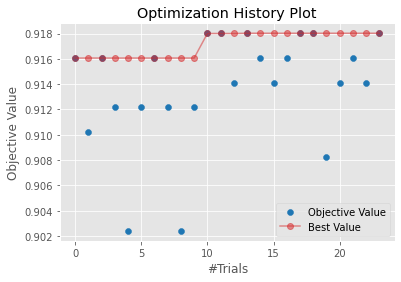

In [53]:
# il plot è aggiornato in maniera asincrona
tuner.plot_best_scores()

In [55]:
tuner.get_status()

<State.COMPLETED: 5>

### Track best results in MLFlow

In [57]:
# get the data from the best trial and track them in MLFLow
# using a myconfig.py file I avoid to show passwords in the NB
from myconfig import config
import os

TRACK_SERVER_URI = config["TRACK_SERVER_URI"]

# the key for succesfull auth is to set these two variables
# see documentation in https://www.mlflow.org/docs/latest/tracking.html
os.environ['MLFLOW_TRACKING_USERNAME'] = config["MLFLOW_TRACKING_USERNAME"]
os.environ['MLFLOW_TRACKING_PASSWORD'] = config['MLFLOW_TRACKING_PASSWORD']

mlflow.set_tracking_uri(TRACK_SERVER_URI)

EXP_NAME = "exp-xgb-adstuner2"

exp_id = mlflow.set_experiment(EXP_NAME)

2022/02/23 17:21:42 INFO mlflow.tracking.fluent: Experiment with name 'exp-xgb-adstuner2' does not exist. Creating a new experiment.


In [58]:
with mlflow.start_run():
    mlflow.log_params(tuner.best_params)
    
    mlflow.log_metric("acc", round(tuner.best_score, 4))
    
    mlflow.end_run()